# Update Database

In [1]:
import pandas as pd
import sqlalchemy as sq
import datetime as dt

usa_df = pd.read_csv('https://covidtracking.com/api/v1/states/daily.csv')
usa_df['total_tests'] = usa_df['positive'] + usa_df['negative']
usa_df['pos_per_tests'] = usa_df['positive']/usa_df['total_tests']
usa_df['date'] = usa_df['date'].astype(str)
usa_df['date'] = usa_df['date'].apply(lambda x: dt.datetime.strptime(x,'%Y%m%d'))
    
world_df = pd.read_csv('https://covid.ourworldindata.org/data/owid-covid-data.csv')
world_df['deaths_per_pos'] = world_df['new_deaths']/world_df['new_cases']
world_df['pos_per_tests'] = world_df['new_cases']/world_df['new_tests']

location = 'sqlite:///covid.db'
cnx = sq.create_engine(location)
usa_df.to_sql('covid_states',con=cnx,if_exists='replace',index=False)
world_df.to_sql('covid_world',con=cnx,if_exists='replace',index=False)

print(f'new_data saved to covid_states and covid_world tables at {location}')

new_data saved to covid_states and covid_world tables at sqlite:///covid.db


# Worldwide

[Source](https://covid.ourworldindata.org/data/)

[Next Step](https://www.statworx.com/blog/plotly-an-interactive-charting-library/)

In [28]:
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns

In [21]:
df_world = pd.read_sql_table('covid_world',cnx, parse_dates='date')
df_world['deaths_per_cases'] = df_world['new_deaths']/df_world['new_cases']

In [22]:
def loc_selector(dataframe,country):
    return dataframe[dataframe['location']==country]

In [23]:
df_usa = loc_selector(df_world,'United States')
df_hungary = loc_selector(df_world,'Hungary')

In [24]:
from matplotlib import dates

In [25]:
def plt_date_formatter(xaxis):
    ax = plt.gca()
    x = dates.date2num(xaxis)    # Convert to maplotlib format
    hfmt = dates.DateFormatter('%m/%d')
    ax.xaxis.set_major_formatter(hfmt)
    return x

In [26]:
def df_cutter(dataframe,loc_list):
    new_df = pd.DataFrame(columns=list(dataframe.columns))
    for i in range(len(loc_list)):
        new_df = new_df.append(dataframe[dataframe['location']==loc_list[i]])
    return new_df

In [27]:
df_world.groupby(['continent'])['location'].unique()['Europe']

array(['Albania', 'Andorra', 'Austria', 'Belarus', 'Belgium',
       'Bosnia and Herzegovina', 'Bulgaria', 'Croatia', 'Cyprus',
       'Czech Republic', 'Denmark', 'Estonia', 'Faeroe Islands',
       'Finland', 'France', 'Germany', 'Gibraltar', 'Greece', 'Guernsey',
       'Hungary', 'Iceland', 'Ireland', 'Isle of Man', 'Italy', 'Jersey',
       'Kosovo', 'Latvia', 'Liechtenstein', 'Lithuania', 'Luxembourg',
       'Macedonia', 'Malta', 'Moldova', 'Monaco', 'Montenegro',
       'Netherlands', 'Norway', 'Poland', 'Portugal', 'Romania', 'Russia',
       'San Marino', 'Serbia', 'Slovakia', 'Slovenia', 'Spain', 'Sweden',
       'Switzerland', 'Ukraine', 'United Kingdom', 'Vatican'],
      dtype=object)

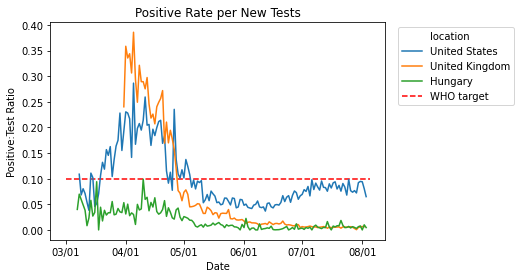

In [29]:
temp_df_global = df_cutter(df_world,['United States','United Kingdom','Hungary'])
xaxis = plt_date_formatter(temp_df_global['date'])

sns.lineplot(xaxis,'pos_per_tests','location',data=temp_df_global)
plt.title('Positive Rate per New Tests')
plt.xlabel('Date')
plt.ylabel('Positive:Test Ratio')
plt.hlines(0.10,dt.date(2020,3,1),dt.date(2020,8,5),color='r',label='WHO target',linestyle='--')
plt.legend(bbox_to_anchor=(1.4,1))


Text(0, 0.5, 'New Cases')

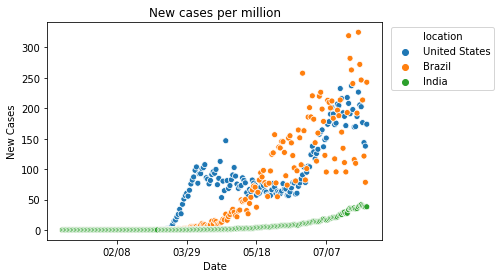

In [30]:
temp_df = df_cutter(df_world,['United States','Brazil','India'])
xaxis = plt_date_formatter(temp_df['date'])

sns.scatterplot(xaxis,'new_cases_per_million','location',data=temp_df)
plt.legend(bbox_to_anchor=(1.35,1))
plt.title('New cases per million')
plt.xlabel('Date')
plt.ylabel('New Cases')

Text(0.5, 0, 'Date')

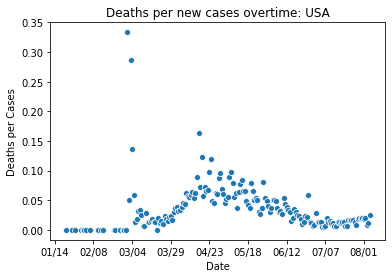

In [31]:
x_usa = plt_date_formatter(df_usa['date'])

sns.scatterplot(x_usa,'deaths_per_cases',data=df_usa)
plt.title('Deaths per new cases overtime: USA')
plt.ylabel('Deaths per Cases')
plt.xlabel('Date')

Text(0.5, 0, 'Date')

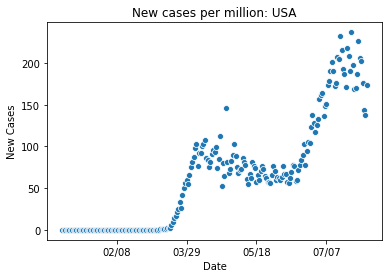

In [32]:
x_usa = plt_date_formatter(df_usa['date'])

sns.scatterplot(x_usa,'new_cases_per_million',data=df_usa)
plt.title('New cases per million: USA')
plt.ylabel('New Cases')
plt.xlabel('Date')

# USA

[Source](https://covidtracking.com/data/api)

In [35]:
df_state = pd.read_sql_table('covid_states',cnx, parse_dates='date')

In [36]:
def state_selector(dataframe,state_list):
    new_df = pd.DataFrame(columns=list(dataframe.columns))
    
    for i in range(len(state_list)):
        new_df = new_df.append(dataframe[dataframe['state']==state_list[i]])
    return new_df

In [37]:
oh_pos = state_selector(df_state,['OH'])['positive']
tx_pos = state_selector(df_state,['TX'])['positive']

<AxesSubplot:>

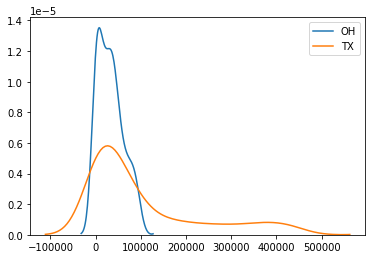

In [38]:
sns.kdeplot(data=oh_pos,label='OH')
sns.kdeplot(data=tx_pos,label='TX')

In [39]:
pos_per_tests = df_state.groupby('date').mean()[['pos_per_tests']].reset_index()

(0.0, 1.0)

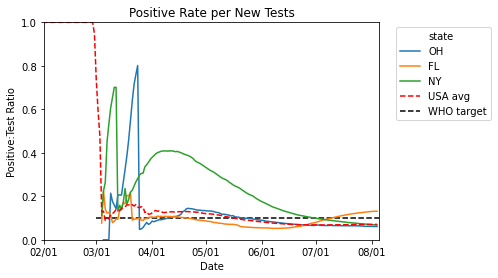

In [40]:
temp_df = state_selector(df_state,['OH','FL','NY'])

plt_date_formatter(temp_df['date'])

sns.lineplot('date','pos_per_tests',hue='state',data=temp_df)
plt.plot('date','pos_per_tests', data=pos_per_tests,label='USA avg',linestyle='--',color='red')

plt.title('Positive Rate per New Tests')
plt.xlabel('Date')
plt.ylabel('Positive:Test Ratio')
plt.hlines(0.10,dt.date(2020,3,1),dt.date(2020,8,5),color='black',label='WHO target',linestyle='--')
plt.legend(bbox_to_anchor=(1.35,1))
plt.xlim(dt.date(2020,2,1),dt.date(2020,8,5))
plt.ylim(0,1)

(0.0, 0.2)

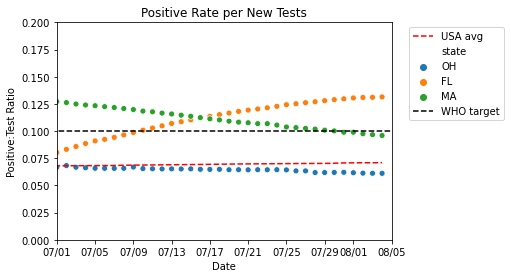

In [41]:
temp_df = state_selector(df_state,['OH','FL','MA'])

plt_date_formatter(temp_df['date'])

sns.scatterplot('date','pos_per_tests',hue='state',data=temp_df)
plt.plot('date','pos_per_tests', data=pos_per_tests,label='USA avg',linestyle='--',color='red')

plt.title('Positive Rate per New Tests')
plt.xlabel('Date')
plt.ylabel('Positive:Test Ratio')
plt.hlines(0.10,dt.date(2020,3,1),dt.date(2020,8,5),color='black',label='WHO target',linestyle='--')
plt.legend(bbox_to_anchor=(1.35,1))
plt.xlim(dt.date(2020,7,1),dt.date(2020,8,5))
plt.ylim(0,0.2)